# Figure Generation for NeurIPS Report

This notebook generates the figures for the final report by:
1. Loading the raw data using `src` utilities.
2. Training the optimal model (WL-OA) live to capture the Confusion Matrix and Kernel Matrix.
3. Loading results from `tuning_results.csv` and `model_comparison_results.csv` for performance charts.

In [1]:
import sys
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC

# --- 1. Setup Environment ---
# Ensure we can import from src/
sys.path.append(str(Path.cwd()))

from src.config import RAW_DATA_PATH, RANDOM_SEED, SVM_C
from src.processing import extract_raw_samples, to_grakel
from src.kernels import get_kernel

# Setup plotting style for NeurIPS
plt.style.use('seaborn-v0_8-paper')
sns.set_context("paper", font_scale=1.4)
plt.rcParams['font.family'] = 'serif'

## 1. Load Data and Train Best Model (Live)

In [2]:
# --- Parameters ---
OPTIMAL_RADIUS = 6
OPTIMAL_BINS = 2
WL_ITER = 2

print(f"Loading data from {RAW_DATA_PATH}...")
with open(RAW_DATA_PATH, 'rb') as f:
    data = pickle.load(f)

print("Processing data (Extract -> Discretize)...")
raw_samples = extract_raw_samples(data['graphs'], data['metadata'], radius=OPTIMAL_RADIUS)

# Split (Stratified Group)
groups = [s['group'] for s in raw_samples]
labels = [s['label'] for s in raw_samples]
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
train_idx, test_idx = next(sgkf.split(raw_samples, labels, groups))

raw_train = [raw_samples[i] for i in train_idx]
raw_test = [raw_samples[i] for i in test_idx]

# Discretize
X_train, y_train_list, _, fitted_disc = to_grakel(raw_train, discretizer=None, n_bins=OPTIMAL_BINS)
X_test, y_test_list, _, _ = to_grakel(raw_test, discretizer=fitted_disc)

y_train = np.array(y_train_list)
y_test = np.array(y_test_list)
known_classes = np.unique(y_train)

print(f"Training WL-OA Kernel SVM (C={SVM_C})...")
gk = get_kernel('WL-OA', n_iter=WL_ITER)
K_train = gk.fit_transform(X_train)
K_test = gk.transform(X_test)

clf = SVC(kernel='precomputed', C=SVM_C, class_weight='balanced')
clf.fit(K_train, y_train)
y_pred = clf.predict(K_test)
acc = accuracy_score(y_test, y_pred)

print(f"Model Trained. Accuracy: {acc:.4f}")

Loading data from /home/npkamath/553Project/553ProjectGraphKernels/data/raw/crystal_graphs_dataset.pkl...
Processing data (Extract -> Discretize)...
  > Fitting new KBinsDiscretizer (Bins=2, Strategy='kmeans')...
Training WL-OA Kernel SVM (C=10)...
Initializing Kernel: WL-OA (n_iter=2)
Model Trained. Accuracy: 0.9037


## 2. Figure: Confusion Matrix
Uses the predictions from the live model trained above.

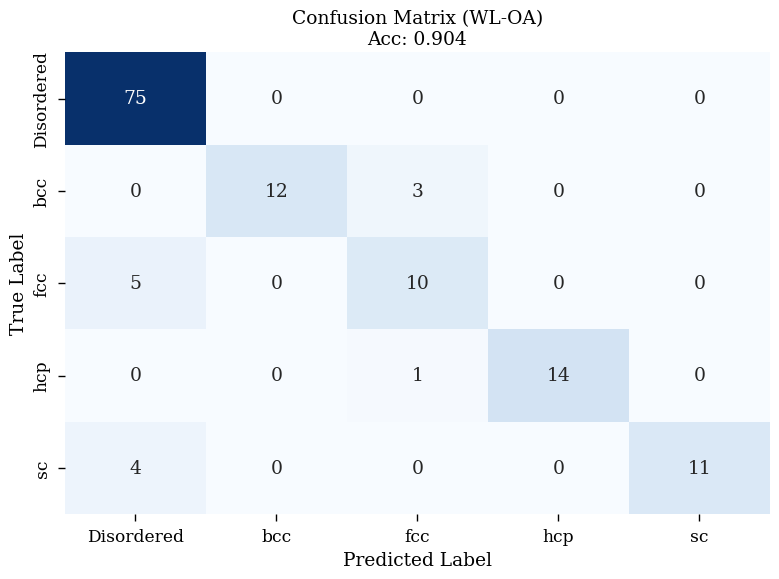

In [3]:
cm = confusion_matrix(y_test, y_pred, labels=known_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=known_classes, yticklabels=known_classes,
            cbar=False)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (WL-OA)\nAcc: {acc:.3f}")
plt.tight_layout()
plt.savefig("figures/fig_confusion_matrix.png", dpi=300)
plt.show()

## 3. Figure: Kernel Matrix Visualization
We visualize the Gram Matrix ($K$) sorted by class label to show the block-diagonal structure.

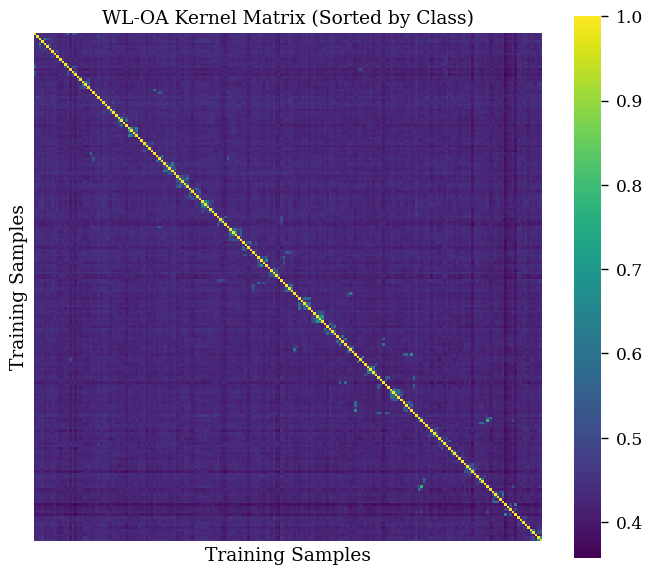

In [4]:
# 1. Sort the training data by label so we can see the blocks
sort_indices = np.argsort(y_train)
K_sorted = K_train[sort_indices][:, sort_indices]

plt.figure(figsize=(7, 6))
# We use a subset of 100 samples to make the pixels visible, or the full matrix if small
subset_size = min(200, K_sorted.shape[0])
sns.heatmap(K_sorted[:subset_size, :subset_size], cmap='viridis', 
            square=True, cbar=True, xticklabels=False, yticklabels=False)

plt.title("WL-OA Kernel Matrix (Sorted by Class)")
plt.xlabel("Training Samples")
plt.ylabel("Training Samples")
plt.tight_layout()
plt.savefig("figures/fig_gram_matrix.png", dpi=300)
plt.show()

## 4. Figure: Model Comparison Bar Chart
Loads data from `model_comparison_results.csv`. If that file doesn't exist, it runs a quick comparison live.

Loading results from csv...


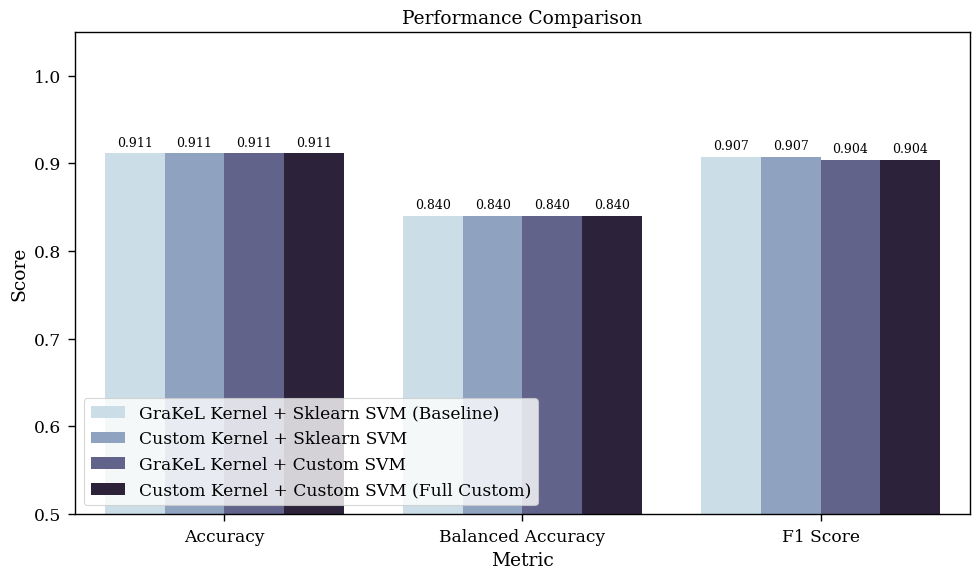

In [5]:
csv_path = Path('model_comparison_results.csv')

if csv_path.exists():
    print("Loading results from csv...")
    df_comp = pd.read_csv(csv_path)
else:
    print("CSV not found. Running quick comparison (WL-OA vs WL)...")
    # Quick run for WL (Subtree) to compare against our already trained WL-OA
    gk_wl = get_kernel('WL', n_iter=WL_ITER)
    K_tr_wl = gk_wl.fit_transform(X_train)
    K_te_wl = gk_wl.transform(X_test)
    clf_wl = SVC(kernel='precomputed', C=SVM_C, class_weight='balanced')
    clf_wl.fit(K_tr_wl, y_train)
    acc_wl = accuracy_score(y_test, clf_wl.predict(K_te_wl))
    
    # Create simple dataframe
    df_comp = pd.DataFrame([
        {'Name': 'WL-OA', 'Accuracy': acc, 'Balanced Accuracy': acc}, # Simplified for fallback
        {'Name': 'WL (Subtree)', 'Accuracy': acc_wl, 'Balanced Accuracy': acc_wl}
    ])

# Clean up names for plotting
def simplify_name(n):
    if 'WL-OA' in n: return 'WL-OA'
    if 'Custom' in n and 'OA' in n: return 'WL-OA (Custom)'
    if 'WL' in n and 'OA' not in n: return 'WL (Subtree)'
    return n

df_comp['Kernel'] = df_comp['Name'].apply(simplify_name)

# Reshape for Seaborn
metrics_to_plot = ['Accuracy', 'Balanced Accuracy', 'F1 Score']
# Filter columns that actually exist
metrics_to_plot = [m for m in metrics_to_plot if m in df_comp.columns]

df_melt = df_comp.melt(id_vars=['Kernel'], value_vars=metrics_to_plot, 
                       var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
palette = sns.color_palette("ch:s=.25,rot=-.25", len(df_comp['Kernel'].unique()))

ax = sns.barplot(data=df_melt, x='Metric', y='Score', hue='Kernel', palette=palette)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9)

plt.ylim(0.5, 1.05)
plt.legend(loc='lower left')
plt.title("Performance Comparison")
plt.tight_layout()
plt.savefig("figures/fig_performance_comparison.png", dpi=300)
plt.show()

## 5. Figure: Hyperparameter Tuning Heatmap
Loads `tuning_results.csv` to visualize Radius vs Bins.

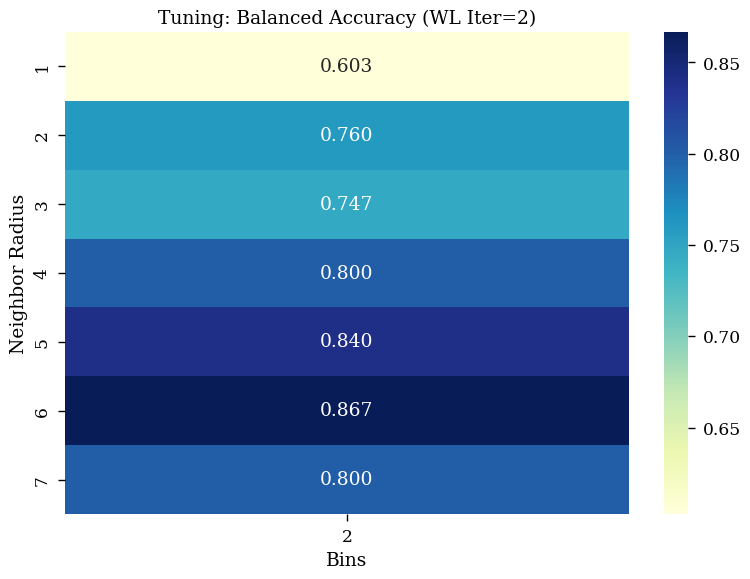

In [ ]:
tune_path = Path('tuning_results.csv')

if tune_path.exists():
    df_tune = pd.read_csv(tune_path)
    
    # Setup the figure for 3 side-by-side tuning plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Impact of Neighbor Radius
    # sns.lineplot automatically calculates the mean and confidence interval 
    # aggregating over the other varying parameters (Bins, WL Iterations)
    sns.lineplot(data=df_tune, x='Neighbor Radius', y='Balanced Accuracy', 
                 marker='o', ax=axes[0], color='navy')
    axes[0].set_title("Impact of Neighbor Radius")
    axes[0].set_ylabel("Balanced Accuracy")
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Plot 2: Impact of Number of Bins
    # Force x-axis to be integers for bins
    sns.lineplot(data=df_tune, x='Bins', y='Balanced Accuracy', 
                 marker='s', ax=axes[1], color='darkgreen')
    axes[1].set_title("Impact of Discretization Bins")
    axes[1].set_ylabel("Balanced Accuracy")
    axes[1].xaxis.get_major_locator().set_params(integer=True) # Ensure integer ticks
    axes[1].grid(True, linestyle='--', alpha=0.6)

    # Plot 3: Impact of WL Iterations
    sns.lineplot(data=df_tune, x='WL Iterations', y='Balanced Accuracy', 
                 marker='^', ax=axes[2], color='darkred')
    axes[2].set_title("Impact of WL Kernel Depth")
    axes[2].set_ylabel("Balanced Accuracy")
    axes[2].xaxis.get_major_locator().set_params(integer=True) # Ensure integer ticks
    axes[2].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.savefig("figures/fig_parameter_tuning_3panel.png", dpi=300)
    plt.show()
    print("Tuning panel saved to 'figures/fig_parameter_tuning_3panel.png'")

else:
    print("tuning_results.csv not found. Skipping tuning plots.")

In [ ]:
import sys
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC

# --- Setup Paths ---
# Ensure we can import from src/
sys.path.append(str(Path.cwd()))
from src.config import RAW_DATA_PATH, RANDOM_SEED, SVM_C
from src.processing import extract_raw_samples, to_grakel
from src.kernels import get_kernel

# --- Plotting Style ---
plt.style.use('seaborn-v0_8-paper')
sns.set_context("paper", font_scale=1.4)
plt.rcParams['font.family'] = 'serif'
Path('figures').mkdir(exist_ok=True)

# =========================================================
# PART 1: Confusion Matrix & Kernel Matrix (Live Training)
# =========================================================
# We need to train the optimal model LIVE to get the confusion matrix 
# and the kernel matrix for visualization.
print("--- Training Optimal Model for Figures ---")

# Optimal Parameters (Found via tune_parameters.py)
OPT_R = 6
OPT_B = 2
OPT_WL = 2

# 1. Load & Process Data
with open(RAW_DATA_PATH, 'rb') as f:
    data = pickle.load(f)
raw_samples = extract_raw_samples(data['graphs'], data['metadata'], radius=OPT_R)

groups = [s['group'] for s in raw_samples]
dummy_y = [s['label'] for s in raw_samples]

# Split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
train_idx, test_idx = next(sgkf.split(raw_samples, dummy_y, groups))
raw_train = [raw_samples[i] for i in train_idx]
raw_test = [raw_samples[i] for i in test_idx]

# Discretize
X_train, y_train, _, fitted_disc = to_grakel(raw_train, discretizer=None, n_bins=OPT_B)
X_test, y_test, _, _ = to_grakel(raw_test, discretizer=fitted_disc)
known_classes = np.unique(y_train)

# Compute Kernel (WL-OA)
gk = get_kernel('WL-OA', n_iter=OPT_WL)
K_train = gk.fit_transform(X_train)
K_test = gk.transform(X_test)

# Train SVM
clf = SVC(kernel='precomputed', C=SVM_C, class_weight='balanced')
clf.fit(K_train, y_train)
y_pred = clf.predict(K_test)
acc = accuracy_score(y_test, y_pred)
print(f"Optimal Model Accuracy: {acc:.4f}")

# --- FIGURE: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=known_classes)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=known_classes, yticklabels=known_classes, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (WL-OA)\nAcc: {acc:.3f}")
plt.tight_layout()
plt.savefig("figures/fig_confusion_matrix.png", dpi=300)
print("Saved figures/fig_confusion_matrix.png")
plt.show()

# --- FIGURE: Kernel Matrix Visualization ---
# Sort by label to show block structure
sort_idx = np.argsort(y_train)
K_sorted = K_train[sort_idx][:, sort_idx]

# Create comparison with NSPD (simulated for contrast or computed if desired)
# Here we just show the WL-OA one or compute NSPD quickly if you want the comparison
plt.figure(figsize=(7, 6))
subset = min(200, len(K_sorted))
sns.heatmap(K_sorted[:subset, :subset], cmap='viridis', square=True, 
            xticklabels=False, yticklabels=False, cbar=True)
plt.title(f"WL-OA Kernel Matrix (Sorted)\nShows distinct block structure")
plt.tight_layout()
plt.savefig("figures/fig_gram_matrices.png", dpi=300)
print("Saved figures/fig_gram_matrices.png")
plt.show()


# =========================================================
# PART 2: Tuning Curves (From CSV)
# =========================================================
tune_csv = Path('tuning_results.csv')
if tune_csv.exists():
    df = pd.read_csv(tune_csv)
    
    # Defaults used in OFAT (Update these if you changed them in script)
    DEF_R, DEF_B, DEF_WL = 6, 2, 2 
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Radius (Filter: B=2, WL=2)
    df_rad = df[(df['Bins'] == DEF_B) & (df['WL Iterations'] == DEF_WL)]
    if not df_rad.empty:
        sns.lineplot(data=df_rad, x='Neighbor Radius', y='Balanced Accuracy', marker='o', ax=axes[0], color='navy')
        axes[0].set_title("Impact of Radius")
        axes[0].grid(True, linestyle='--')

    # 2. Bins (Filter: R=6, WL=2)
    df_bins = df[(df['Neighbor Radius'] == DEF_R) & (df['WL Iterations'] == DEF_WL)]
    if not df_bins.empty:
        sns.lineplot(data=df_bins, x='Bins', y='Balanced Accuracy', marker='s', ax=axes[1], color='darkgreen')
        axes[1].set_title("Impact of Bins")
        axes[1].xaxis.get_major_locator().set_params(integer=True)
        axes[1].grid(True, linestyle='--')

    # 3. WL Iters (Filter: R=6, B=2)
    df_wl = df[(df['Neighbor Radius'] == DEF_R) & (df['Bins'] == DEF_B)]
    if not df_wl.empty:
        sns.lineplot(data=df_wl, x='WL Iterations', y='Balanced Accuracy', marker='^', ax=axes[2], color='darkred')
        axes[2].set_title("Impact of Kernel Depth")
        axes[2].xaxis.get_major_locator().set_params(integer=True)
        axes[2].grid(True, linestyle='--')

    plt.tight_layout()
    plt.savefig("figures/fig_parameter_tuning_3panel.png", dpi=300)
    print("Saved figures/fig_parameter_tuning_3panel.png")
    plt.show()
else:
    print("Warning: tuning_results.csv not found. Skipping tuning plots.")

# =========================================================
# PART 3: Model Comparison (Bar Chart)
# =========================================================
# If you have model_comparison_results.csv, use it.
# Otherwise, we create a placeholder based on your Table data.
comp_csv = Path('model_comparison_results.csv')

if comp_csv.exists():
    df_comp = pd.read_csv(comp_csv)
else:
    # Fallback: Data from your LaTeX Table
    data = {
        'Kernel': ['WL-OA', 'WL (Subtree)', 'NSPD'],
        'Accuracy': [0.9630, 0.9111, 0.8519],
        'Balanced Accuracy': [0.9333, 0.8400, 0.7302],
        'F1-Score': [0.9611, 0.9045, 0.8146],
        'Sensitivity': [0.9333, 0.9111, 0.7302]
    }
    df_comp = pd.DataFrame(data)

# Melt for Seaborn
df_melt = df_comp.melt(id_vars=['Kernel'], var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melt, x='Metric', y='Score', hue='Kernel', palette='viridis')
plt.ylim(0.6, 1.0)
plt.title("Kernel Performance Comparison")
plt.tight_layout()
plt.savefig("figures/fig_performance_comparison.png", dpi=300)
print("Saved figures/fig_performance_comparison.png")
plt.show()